In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from custom_tools import CustomInstrumentJ1808, CustomBackground_BlackBody, CustomInterstellar, get_T_in_log10_Kelvin, plot_2D_pulse, get_mids_from_edges, CustomSignal, SynthesiseData
from matplotlib import cm

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 2.0.0               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Imported GetDist version: 1.4
Imported nestcheck version: 0.2.1


In [2]:
################################## INSTRUMENT #################################
channel_low = 20
channel_hi = 300 #600 #500 #300 commented numbers work
max_input = 1400 #2000 #1800 #1400

NICER = CustomInstrumentJ1808.from_response_files(ARF = '../model_data/J1808/ni2584010103mpu7_arf_aeff.txt',
                                                  RMF = '../model_data/J1808/ni2584010103mpu7_rmf_matrix.txt',
                                                  channel_edges = '../model_data/J1808/ni2584010103mpu7_rmf_energymap.txt',
                                                  channel_low=channel_low,
                                                  channel_hi=channel_hi,
                                                  max_input=max_input)

Setting channels for loaded instrument response (sub)matrix...
Channels set.
No parameters supplied... empty subspace created.


# Instrument plots

In [3]:
# RMF = np.loadtxt('../model_data/J1808/ni2584010103mpu7_rmf_matrix.txt')
# plt.imshow(RMF, cmap='jet')
# plt.colorbar()

In [4]:
# ARF = np.loadtxt('../model_data/J1808/ni2584010103mpu7_arf_aeff.txt',skiprows=2)
# plt.plot(ARF)

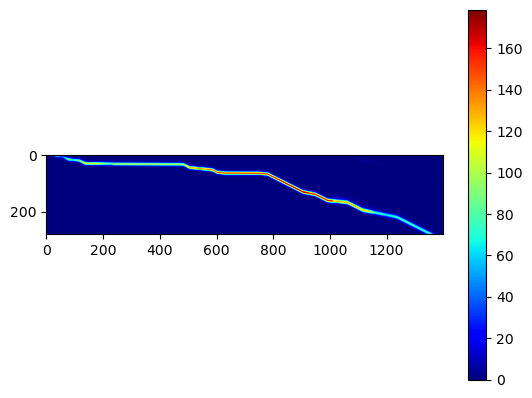

In [5]:
plt.imshow(NICER.matrix, cmap='jet')
plt.colorbar()


# setup interstellar and background

In [6]:
value = 1.17 # 10^21 cm^-2
interstellar = CustomInterstellar.from_SWG("/home/bas/Documents/Projects/x-psi/xpsi-bas-fork/AMXPs/model_data/n_H/TBnew/tbnew0.14.txt", bounds=(None, None), value=value)


Creating parameter:
    > Named "column_density" with bounds [1.000e-03, 2.000e+00] and initial value 1.170e+00.
    > Units of 10^21 cm^-2.


In [7]:
# nH = np.loadtxt('/home/bas/Documents/Projects/x-psi/xpsi-bas-fork/AMXPs/model_data/n_H/TBnew/tbnew0.14.txt')
# plt.plot(nH[:,2])

In [8]:
T_keV = 0.3 #keV #0.3 keV for Kajava+ 2011
T_log10_Kelvin = get_T_in_log10_Kelvin(T_keV)

# background['background_BB_temperature'] = T_log10_Kelvin

distance = 0.35 #  units of 10 kpc
BB_radius = 25 # km # 55 km for Kajava+ 2011
BB_normalisation = (BB_radius/distance)**2  # (km / 10 kpc)^2


values = {'T_BB': T_log10_Kelvin,
          'K_BB': BB_normalisation
         } 

background = CustomBackground_BlackBody(bounds=(None, None), values=values, interstellar = interstellar)

Creating parameter:
    > Named "T_BB" with bounds [3.000e+00, 1.000e+01] and initial value 6.542e+00.
    > Background black body temperature in log10 Kelvin.
Creating parameter:
    > Named "K_BB" with bounds [1.000e+00, 1.000e+08] and initial value 5.102e+03.
    > Background black body normalisation in (km / 10 kpc)^2.


In [9]:
import numpy as np
phases = np.linspace(0.0, 1.0, 33)
phases

array([0.     , 0.03125, 0.0625 , 0.09375, 0.125  , 0.15625, 0.1875 ,
       0.21875, 0.25   , 0.28125, 0.3125 , 0.34375, 0.375  , 0.40625,
       0.4375 , 0.46875, 0.5    , 0.53125, 0.5625 , 0.59375, 0.625  ,
       0.65625, 0.6875 , 0.71875, 0.75   , 0.78125, 0.8125 , 0.84375,
       0.875  , 0.90625, 0.9375 , 0.96875, 1.     ])

In [10]:
l_edges = np.logspace(np.log10(3),np.log10(200),100, base=10.)
l_mids = get_mids_from_edges(l_edges)

# Angstrom -> keV
# E = hf = hc/lambda
h = 4.136e-15 #eV s (electronvolt seconds)
c = 2.998e8 #m/s (meters per second)
hc = h*c/1000*10**10 # keV Anstrom

pe_edges = np.flipud(hc/l_mids)  # keV



In [11]:
# background(energy_edges = pe_edges, phases=phases)
pe_mids = get_mids_from_edges(pe_edges)
# print(pe_mids)

background(energy_edges = NICER.energy_edges, phases=phases)
NICER.energy_mids = get_mids_from_edges(NICER.energy_edges)
# print(NICER.energy_mids)

In [12]:
# plt.plot(NICER.energy_edges, 'x')

In [13]:
# plt.imshow(background.incident_background, aspect='auto')
# plt.colorbar()

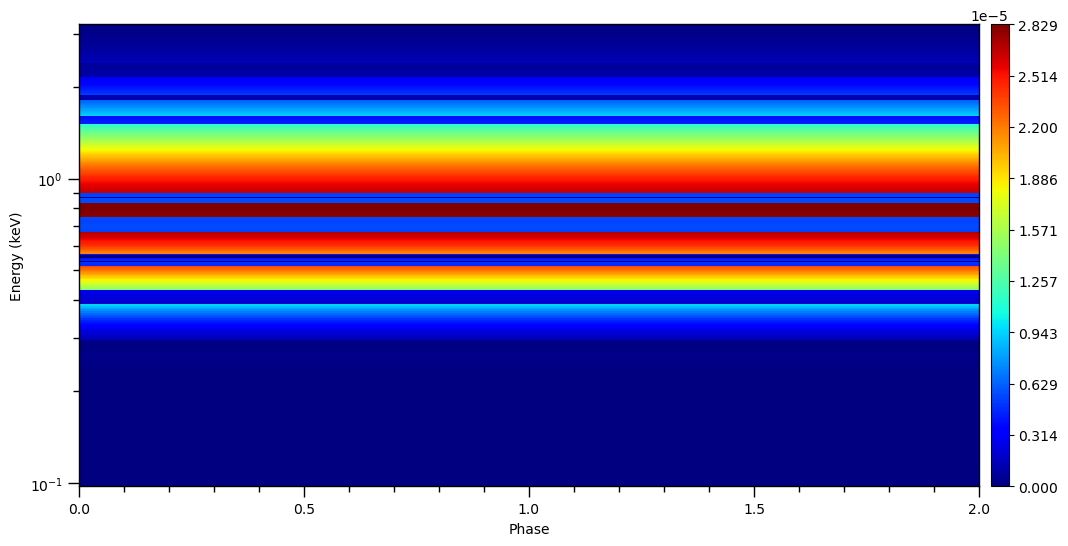

In [14]:
ax = plot_2D_pulse((background.incident_background,),
                   x=phases,
                   shift = np.array([0.]),
                   y=NICER.energy_edges[:-1], # pe_edges[:-1], # 
                   ylabel=r'Energy (keV)',
                   cm=cm.jet,
                   num_rotations=2.0,
                   normalize=False)

In [15]:
print('incident photons/cm^2/s: ', np.sum(background.incident_background[:,0]))

incident photons/cm^2/s:  0.005921788537432842


Text(0, 0.5, 'photons/s/cm^2/bin')

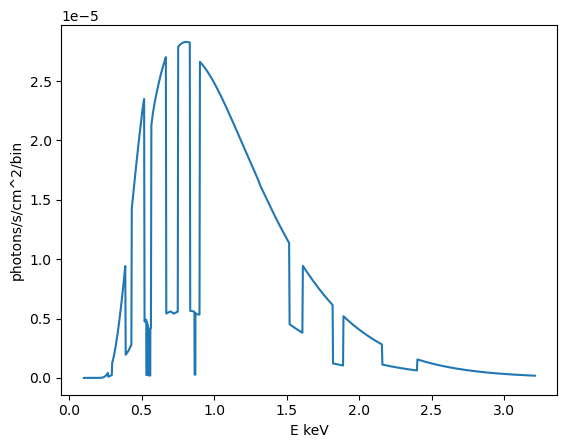

In [16]:
photonflux = background.incident_background[:,0]

# plt.plot(pe_mids, photonflux)
plt.plot(NICER.energy_mids, photonflux)

plt.xlabel('E keV')
plt.ylabel('photons/s/cm^2/bin')
# plt.ylabel('keV/s/cm^2')

In [17]:
# pe_mids[np.argmax(photonflux)]
NICER.energy_mids[np.argmax(photonflux)]

0.8075000000000001

In [18]:
exposure_time = 1.36374e5  # seconds
background.incident_background *= exposure_time #photons/cm^2/bin


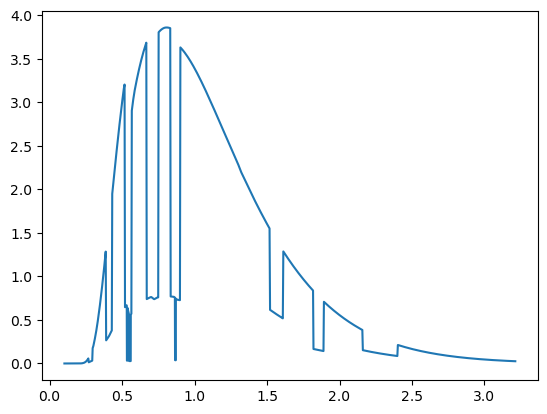

In [19]:
plt.plot(NICER.energy_mids,background.incident_background[:,0])

In [20]:
_data = SynthesiseData(np.arange(channel_low,channel_hi), phases, 0, channel_hi-channel_low-1) #Apparently some hardcoded stuff for NICER

################################## SIGNAL ###################################
signal = CustomSignal(data = _data,
                        instrument = NICER, #Instrument
                        background = background,
                        interstellar = interstellar,
                        cache = True,
                        prefix='Instrument')

Setting channels for event data...
Channels set.
Creating parameter:
    > Named "phase_shift" with fixed value 0.000e+00.
    > The phase shift for the signal, a periodic parameter [cycles].
No data... can synthesise data but cannot evaluate a likelihood function.


In [21]:
signal._data.phases

array([0.     , 0.03125, 0.0625 , 0.09375, 0.125  , 0.15625, 0.1875 ,
       0.21875, 0.25   , 0.28125, 0.3125 , 0.34375, 0.375  , 0.40625,
       0.4375 , 0.46875, 0.5    , 0.53125, 0.5625 , 0.59375, 0.625  ,
       0.65625, 0.6875 , 0.71875, 0.75   , 0.78125, 0.8125 , 0.84375,
       0.875  , 0.90625, 0.9375 , 0.96875, 1.     ])

In [29]:
signal.data.phases

array([0.     , 0.03125, 0.0625 , 0.09375, 0.125  , 0.15625, 0.1875 ,
       0.21875, 0.25   , 0.28125, 0.3125 , 0.34375, 0.375  , 0.40625,
       0.4375 , 0.46875, 0.5    , 0.53125, 0.5625 , 0.59375, 0.625  ,
       0.65625, 0.6875 , 0.71875, 0.75   , 0.78125, 0.8125 , 0.84375,
       0.875  , 0.90625, 0.9375 , 0.96875, 1.     ])

In [22]:
registered_background = NICER(signal._background.incident_background,
                              signal._input_interval_range,
                              signal._data.index_range)

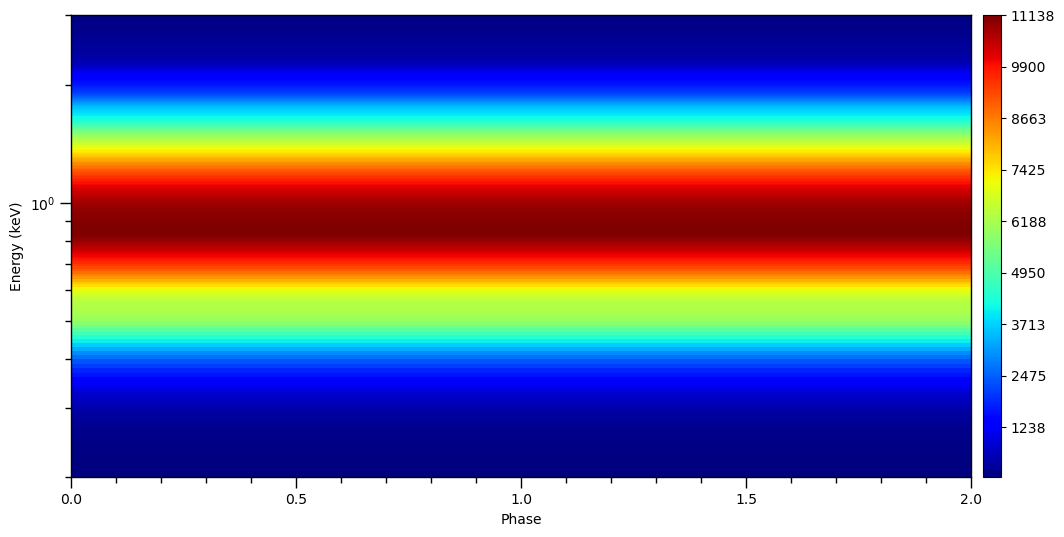

In [23]:
NICER.channel_values = get_mids_from_edges(NICER.channel_edges)

ax = plot_2D_pulse((registered_background,),
                   x=phases,
                   shift = np.array([0.]),
                   y=NICER.channel_values,  # NICER.channel_edges[:-1]
                   ylabel=r'Energy (keV)',
                   cm=cm.jet,
                   num_rotations=2.0,
                   normalize=False)

In [24]:
expected_counts = np.sum(registered_background)
print(expected_counts)

38787202.870019816


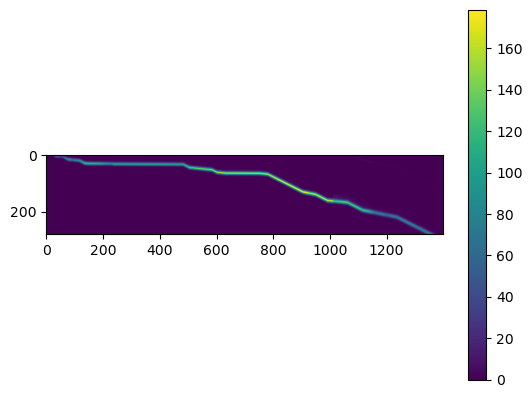

In [25]:
plt.imshow(NICER.matrix)
plt.colorbar()